<a href="https://colab.research.google.com/github/djdunc/casa0018/blob/main/Week5/CASA0018_5_ObjectDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Detection example

This Colab runs through a basic example of creating an object detector that will load an image and highlight known objects. It uses the COCO dataset and a number of pretrained models from the TF2 [Object Detection Model Zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md).

Example based on the [TensorFlow tutorial](https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/tf2_object_detection.ipynb#scrollTo=-y9R0Xllefec) and the example [here](https://www.analyticsvidhya.com/blog/2020/04/build-your-own-object-detection-model-using-tensorflow-api/).  

To start we import our dependencies.

In [ ]:
import os
import pathlib

import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from six.moves.urllib.request import urlopen

import tensorflow as tf
import tensorflow_hub as hub

tf.get_logger().setLevel('ERROR')

Clone the model repo into our contents folder over on the left.

In [ ]:
# Clone the tensorflow models repository
!git clone --depth 1 https://github.com/tensorflow/models

We need to setup the object detection packages ready for use - to do this we compile the protobufs - (for those interested more info is available here:  https://developers.google.com/protocol-buffers/docs/pythontutorial) and install the object_detection package.

In [ ]:
%%bash
sudo apt install -y protobuf-compiler
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

And then load in some dependencies from the object_detection packages.

In [ ]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import ops as utils_ops

%matplotlib inline

Next up define a helper function to simplify loading in image files and define the list of models we want to expose from the model zoo (note this is a subset of those available, add more here if you want them to be added to the drop down menu further down the Colab). List of tuples with Human Keypoints for the COCO 2017 dataset. This is needed for models with keypoints.

In [ ]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  image = None
  if(path.startswith('http')):
    response = urlopen(path)
    image_data = response.read()
    image_data = BytesIO(image_data)
    image = Image.open(image_data)
  else:
    image_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(image_data))

  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (1, im_height, im_width, 3)).astype(np.uint8)

ALL_MODELS = {
'CenterNet HourGlass104 512x512' : 'https://tfhub.dev/tensorflow/centernet/hourglass_512x512/1',
'CenterNet HourGlass104 Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/hourglass_512x512_kpts/1',
'CenterNet Resnet50 V1 FPN 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v1_fpn_512x512/1',
'CenterNet Resnet50 V2 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v2_512x512/1',
'EfficientDet D0 512x512' : 'https://tfhub.dev/tensorflow/efficientdet/d0/1',
'SSD MobileNet v2 320x320' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2',
'SSD MobileNet V2 FPNLite 320x320' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_320x320/1',
'SSD ResNet50 V1 FPN 640x640 (RetinaNet50)' : 'https://tfhub.dev/tensorflow/retinanet/resnet50_v1_fpn_640x640/1',
'SSD ResNet101 V1 FPN 640x640 (RetinaNet101)' : 'https://tfhub.dev/tensorflow/retinanet/resnet101_v1_fpn_640x640/1',
'SSD ResNet152 V1 FPN 640x640 (RetinaNet152)' : 'https://tfhub.dev/tensorflow/retinanet/resnet152_v1_fpn_640x640/1',
'Faster R-CNN ResNet50 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_640x640/1',
'Faster R-CNN ResNet101 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_640x640/1',
'Faster R-CNN ResNet152 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_640x640/1',
'Faster R-CNN Inception ResNet V2 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_640x640/1',
'Mask R-CNN Inception ResNet V2 1024x1024' : 'https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1'

}

COCO17_HUMAN_POSE_KEYPOINTS = [(0, 1),
 (0, 2),
 (1, 3),
 (2, 4),
 (0, 5),
 (0, 6),
 (5, 7),
 (7, 9),
 (6, 8),
 (8, 10),
 (5, 6),
 (5, 11),
 (6, 12),
 (11, 12),
 (11, 13),
 (13, 15),
 (12, 14),
 (14, 16)]

The code below creates an array of the labels used in the models so that we can associate a class number to a human readable label - e.g. "person"


In [ ]:
PATH_TO_LABELS = './models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

Select the model type to be used.

Tip: if you want to read more details about the selected model, you can follow the link (model handle) and read aditional documentation on TF Hub. After you select a model, we will print the handle to make it easier.

In [ ]:
model_display_name = "Faster R-CNN ResNet50 V1 640x640" #@param ["CenterNet HourGlass104 512x512", "CenterNet HourGlass104 Keypoints 512x512", "CenterNet Resnet50 V1 FPN 512x512", "CenterNet Resnet50 V2 512x512", "EfficientDet D0 512x512", "SSD MobileNet v2 320x320", "SSD MobileNet V2 FPNLite 320x320", "SSD ResNet50 V1 FPN 640x640 (RetinaNet50)", "SSD ResNet101 V1 FPN 640x640 (RetinaNet101)", "SSD ResNet152 V1 FPN 640x640 (RetinaNet152)", "Faster R-CNN ResNet50 V1 640x640", "Faster R-CNN ResNet101 V1 640x640", "Faster R-CNN ResNet152 V1 640x640", "Faster R-CNN Inception ResNet V2 640x640", "Mask R-CNN Inception ResNet V2 1024x1024"]
model_handle = ALL_MODELS[model_display_name]

print('Selected model:'+ model_display_name)
print('Model Handle at TensorFlow Hub: {}'.format(model_handle))

Selected model:Faster R-CNN ResNet50 V1 640x640
Model Handle at TensorFlow Hub: https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_640x640/1


Next up we load pre-trained model weights from the TensorFlow Hub

In [ ]:
print('loading model...')
hub_model = hub.load(model_handle)
print('model loaded!')

loading model...
model loaded!


The code below runs for each image inference. It takes an image, converts it into an input tensor for the model and outputs results based on the type of model being used. To inspect what keys are available for the model used print out `output_dict.keys()`

In [ ]:
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  output_dict = model(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  #print(output_dict.keys())
  #print(output_dict['num_detections'])

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

Show_inference calls the inference method above and visualises the results. It uses visualisation_utils functions which can be found at https://github.com/tensorflow/models/blob/master/research/object_detection/utils/visualization_utils.py  

Experiment with changing the max_boxes_to_draw and min_score_thresh to see how results are displayed. 

In [ ]:
def show_inference(model, image_path):
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = np.array(Image.open(image_path))
  # Actual detection.
  output_dict = run_inference_for_single_image(model, image_np)

  # Visualization of the results of a detection.
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=2,
      max_boxes_to_draw=30,
      min_score_thresh=.50)

  display(Image.fromarray(image_np))

There are a couple of images built into this repo but if you want to test the code with your images, just add path to the images to the `TEST_IMAGE_PATHS`.

To see what categories are in the COCO dataset to help you choose which images to use [see this repo](https://tech.amikelive.com/node-718/what-object-categories-labels-are-in-coco-dataset/). 


Be careful: when using images with an alpha channel, the model expect 3 channels images and the alpha will count as a 4th.

In [ ]:
PATH_TO_TEST_IMAGES_DIR = pathlib.Path('models/research/object_detection/test_images')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg")))
TEST_IMAGE_PATHS

[PosixPath('models/research/object_detection/test_images/IMG_4755.jpg'),
 PosixPath('models/research/object_detection/test_images/P1050418.jpg'),
 PosixPath('models/research/object_detection/test_images/image1.jpg'),
 PosixPath('models/research/object_detection/test_images/image2.jpg')]

Selected model:Faster R-CNN ResNet50 V1 640x640
Model Handle at TensorFlow Hub: https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_640x640/1


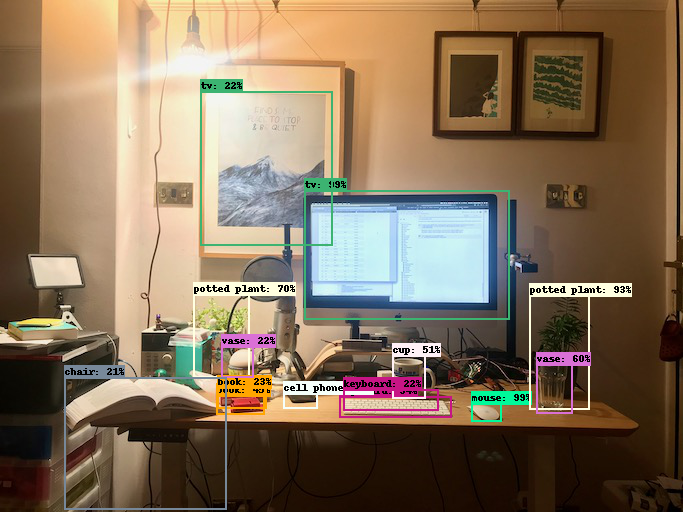

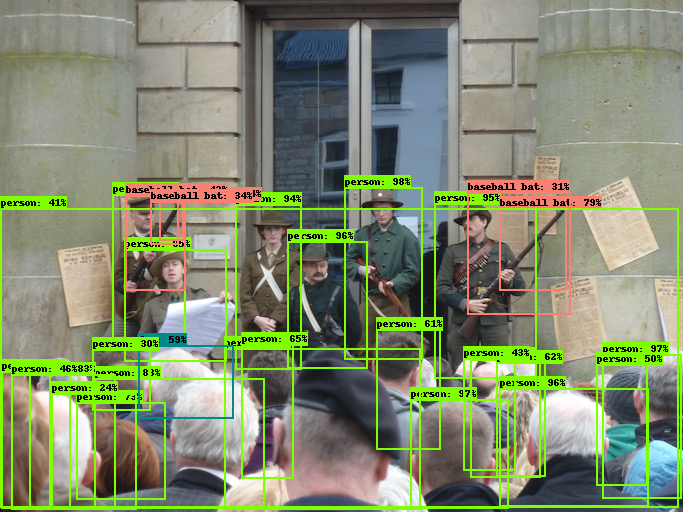

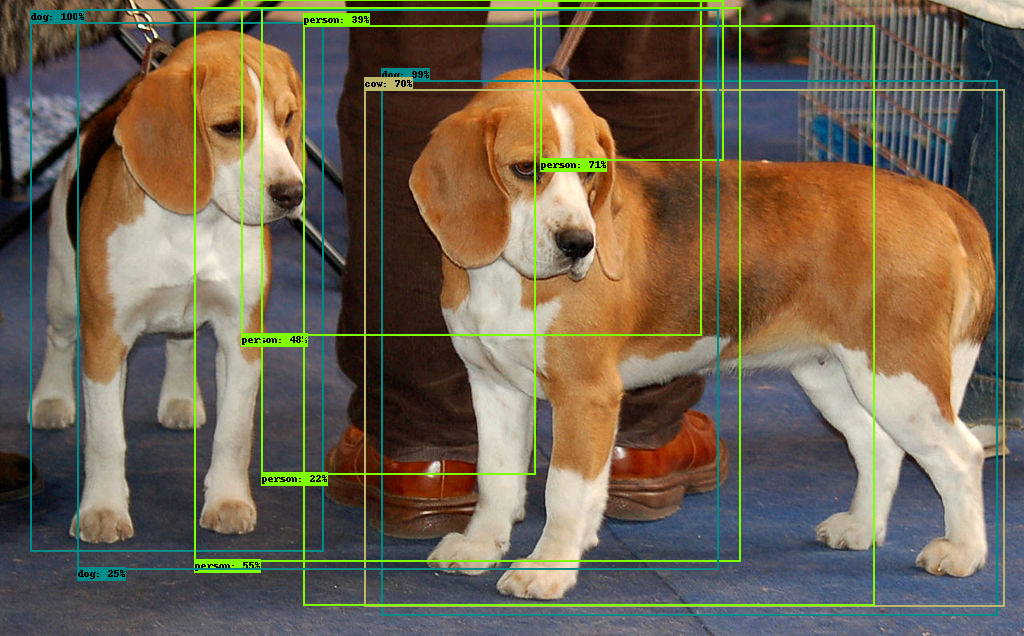

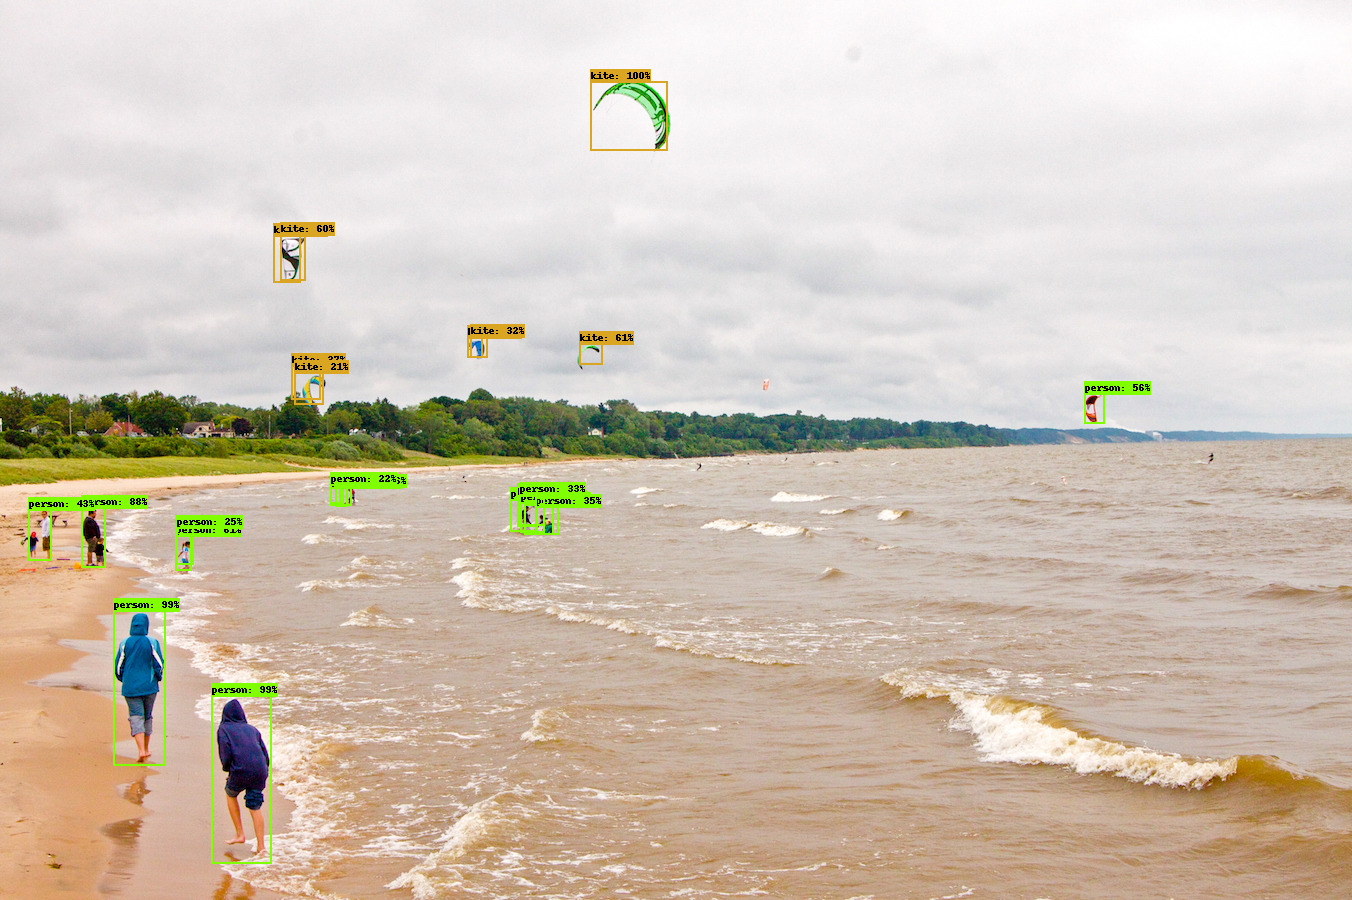

In [ ]:
print('Selected model:'+ model_display_name)
print('Model Handle at TensorFlow Hub: {}'.format(model_handle))

for image_path in TEST_IMAGE_PATHS:
  show_inference(hub_model, image_path)

# Whats next?

Once you have a version of the object detector working start to experiment with different settings for how the data is visualised and explore how the different models create different results. Some questions you may want to ponder (and which will be useful for thinking about your final coursework) include:
1. Which models give the best results? 
2. What does best mean? 
3. Does it change with different images? 
4. Do different models take different times to load? 
5. Why is that? 
6. Take a look at the model structures - does that explain why some take longer to load than others?